# Train and evaluate model

This notebook recreates Table 1 from the manuscript. We train a basic CNN encoder from scratch on a dataset of sparse polynomials. We then evaluate reconstruction performance on a set of basis systems from across the sciences. 

Our coding framework is based on a Click interface and we make use of that in this notebook by running the basic steps in the pipeline through shell commands. 


In [1]:
import os
import subprocess
from src.utils import get_command_defaults, ensure_dir, write_yaml, update_yaml
from src.train import load_model, train_model, run_epoch
from src.data import load_dataset, SystemFamily

## Generate data
First, we generate both the training and testing sets. The former will be a set of vector fields corresponding to polynomial ODEs of degree at most 3 and having sparse coefficients. The testing set will be vector fields representing the flows of 10 types of sytsems drawn from across the sciences. In all cases, we work with planar (i.e. two-dimensional systems). 

First, we set some basic parameters, including the types of training and testing data and the number of their samples. 

In [11]:
## Generate data

data_dir = '/home/mgricci/data/phase2vec' # Alter to change where all of the phase2vec data will be saved. 

# Edit the data included in training and testing here. 
train_data_names = ['polynomial']
test_data_names  = ['saddle_node', 'pitchfork', 'transcritical',
                    'selkov', 'homoclinic', 'vanderpol',
                    'simple_oscillator', 'fitzhugh_nagumo']

train_system_classes = []
test_system_classes = []
for n, names in enumerate([train_data_names, test_data_names]):
    for system in [SystemFamily(data_name=name) for name in names]:
        if n == 0:
            train_system_classes += [system.data_name + ' ' + str(i) for i in range(len(system.param_groups))]
        else:
            test_system_classes += [system.data_name + ' ' + str(i) for i in range(len(system.param_groups))]

num_train_classes = len(train_system_classes)
num_test_classes = len(test_system_classes)

# Edit the number of total samples from each data set here.
#By default, each set is divied further into a base and validation set at a 75/100 split. This can be altered below. 
num_train_samples = 10000 # total number of train/val samples
num_test_samples  = 2000 # total number of test samples. Note these are split themselves automatically into a regular and a validation component, but they can be combined. 
device            = 'cpu' # set to `cpu` if cuda not available

# Leave this untouched unless you want to change how parameters from each system are sampled and the proportions of each system in the data set.
test_samplers    = ['uniform'] * len(test_data_names)
test_props       = [str(1. / len(test_data_names))] * len(test_data_names)
test_data_names   = '-s ' +  ' -s '.join(test_data_names)
test_samplers     = '-sp ' +  ' -sp '.join(test_samplers)
test_props = '-c ' +  ' -c '.join(test_props)

Next, we call the actual shell commands for generating the data. These commands will make two directories, called `polynomial` and `classical`, corresponding to train and test sets, inside your `data_dir`. 

In order to alter the validation proportion, $p$, add the flag `--val-size <p>` where $p\in (0,1)$. 

In [4]:
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name polynomial --num-samples {num_train_samples} --data-set-name polynomial --system-names {train_data_names[0]}', shell=True)
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name classical --num-samples {num_test_samples} --data-set-name classical {test_data_names} {test_samplers} {test_props}', shell=True)

TypeError: 'int' object is not subscriptable

## Instantiate `phase2vec` encoder. 

We build the embedding CNN. We use the default parameters which we access by fetching the default arguments from the click command `generate_net_config`. To edit these parameters, alter the values of the dictionary `net_info`. 

* **model_type** (str): which of the pre-built architectures from _models.py to load. Make your own by combining modules from _modules.py 
* **latent_dim** (int): embedding dimension
* Continue...

In [3]:
## Set net parameters
from src.cli._cli import generate_net_config

net_info = get_command_defaults(generate_net_config)
model_type = net_info['net_class']

# These parameters are not considered architectural parameters for the net, so we delete them before they're passed to the net builder. 
del net_info['net_class']
del net_info['output_file']

net = load_model(model_type, pretrained_path=None, device=device, **net_info).to(device)

## Set training parameters and load data. 

Next, we set the optimization parameters for training. As before, we fetch the default arguments from the relevant click command, `call_train`. These parameters can be updated by altering the values of the dictionary `train_info`. 

In [55]:
## Set training parameters
from src.cli._cli import call_train

train_info = get_command_defaults(call_train)
train_info['exp_name']   = 'basic_train'
train_info['log_dir']    = '/home/mgricci/runs'
train_info['num_epochs'] = 25
train_info['beta'] = 0.0


# These are only used by the click interface. 
del train_info['model_save_dir']
del train_info['seed']
del train_info['config_file']

# Set some training paths

pretrained_path = None # Replace with model_save_dir in order to load a pretrained model
model_save_dir  = os.path.join('/home/mgricci/phase2vec/', train_info['exp_name'])
ensure_dir(train_info['log_dir'])

# Where is training data stored? 
train_data_path = os.path.join(data_dir, 'polynomial')

# Load training data. 
X_train, X_val, y_train, y_val, p_train, p_val = load_dataset(train_data_path)

Now, we actually train the model. 

In [56]:
# Train the model
net = train_model(X_train, X_val,
                  y_train, y_val,
                  p_train, p_val,
                  net,**train_info)

# Save it
from torch import save
save(net.state_dict(), os.path.join(model_save_dir, 'model.pt'))

Running Epoch 0
Training: Total loss: 0.84, Recon loss: 0.84,  Sparsity loss: 0.32, Parameter loss: 3.20
Validating: Total loss: 0.66, Recon loss: 0.66,  Sparsity loss: 0.36, Parameter loss: 3.27
Running Epoch 1
Training: Total loss: 0.69, Recon loss: 0.69,  Sparsity loss: 0.39, Parameter loss: 3.34
Validating: Total loss: 0.61, Recon loss: 0.61,  Sparsity loss: 0.40, Parameter loss: 3.37
Running Epoch 2
Training: Total loss: 0.65, Recon loss: 0.65,  Sparsity loss: 0.43, Parameter loss: 3.44
Validating: Total loss: 0.56, Recon loss: 0.56,  Sparsity loss: 0.43, Parameter loss: 3.47
Running Epoch 3
Training: Total loss: 0.62, Recon loss: 0.62,  Sparsity loss: 0.45, Parameter loss: 3.50
Validating: Total loss: 0.53, Recon loss: 0.53,  Sparsity loss: 0.45, Parameter loss: 3.50
Running Epoch 4
Training: Total loss: 0.60, Recon loss: 0.60,  Sparsity loss: 0.47, Parameter loss: 3.55
Validating: Total loss: 0.51, Recon loss: 0.51,  Sparsity loss: 0.46, Parameter loss: 3.54
Running Epoch 5
Trai

In [57]:
import numpy as np
import pdb

results_dir = f'/home/mgricci/results/phase2vec/{train_info["exp_name"]}'
ensure_dir(results_dir)
# Load testing data

test_data_path = os.path.join(data_dir, 'classical')
X_test1, X_test2, y_test1, y_test2, p_test1, p_test2 = load_dataset(test_data_path)
X_test = np.concatenate([X_test1, X_test2])
y_test = np.concatenate([y_test1, y_test2])
p_test = np.concatenate([p_test1, p_test2])

## Evaluate average performance on each data set. 

In [58]:
## Evaluate
import numpy as np
import pandas as pd
loss_dict = {}
embeddings = []
for label in np.unique(y_test):
    
    data   = np.array([datum for (d, datum) in enumerate(X_test) if y_test[d] == label])
    pars   = np.array([par for (p, par) in enumerate(p_test) if y_test[p] == label])
    labels = np.ones(len(data)) * label

    losses, embds = run_epoch(data, labels, pars,
                              net, 0, None,
                              train=False,
                              batch_size=train_info['batch_size'],
                              beta=train_info['beta'],
                              fp_normalize=train_info['fp_normalize'],
                              device=train_info['device'],
                              return_embeddings=True)
    avg_losses = [np.mean(loss) for loss in losses]
    loss_dict[test_system_classes[label]] = avg_losses
    embeddings+=(list(embds.detach().cpu().numpy()))
df = pd.DataFrame(data=loss_dict)
df.index = ['Total', 'Recon', 'Sparsity', 'Param']
df.to_pickle(os.path.join(results_dir, 'results.pkl'))

embeddings = np.array(embeddings)
np.save(os.path.join(results_dir,'embeddings.npy'), embeddings)


In [59]:
df

,saddle_node 0,saddle_node 1,pitchfork 0,pitchfork 1,transcritical 0,transcritical 1,selkov 0,selkov 1,homoclinic 0,homoclinic 1,vanderpol 0,simple_oscillator 0,simple_oscillator 1,fitzhugh_nagumo 0,fitzhugh_nagumo 1
Total,0.362057,0.421243,0.329085,0.482676,0.410227,0.496073,1.074760,0.994522,0.370133,0.314186,0.488284,0.255787,0.308863,0.729826,0.730193
Recon,0.362057,0.421243,0.329085,0.482676,0.410227,0.496073,1.074760,0.994522,0.370133,0.314186,0.488284,0.255787,0.308863,0.729826,0.730193
Sparsity,1.404883,1.103480,1.286413,0.856791,1.204930,1.364452,0.788985,0.787251,0.959491,0.993989,1.138886,0.889979,0.488889,0.600198,0.606550
Param,0.051810,0.050840,0.070158,0.111769,0.052432,0.058324,2.613230,2.640003,0.413941,0.337435,3.214087,0.127735,0.216078,3.671495,3.687999


## Visualize Embeddings
Finally, let's plot the first two PCA components of the embeddings. 

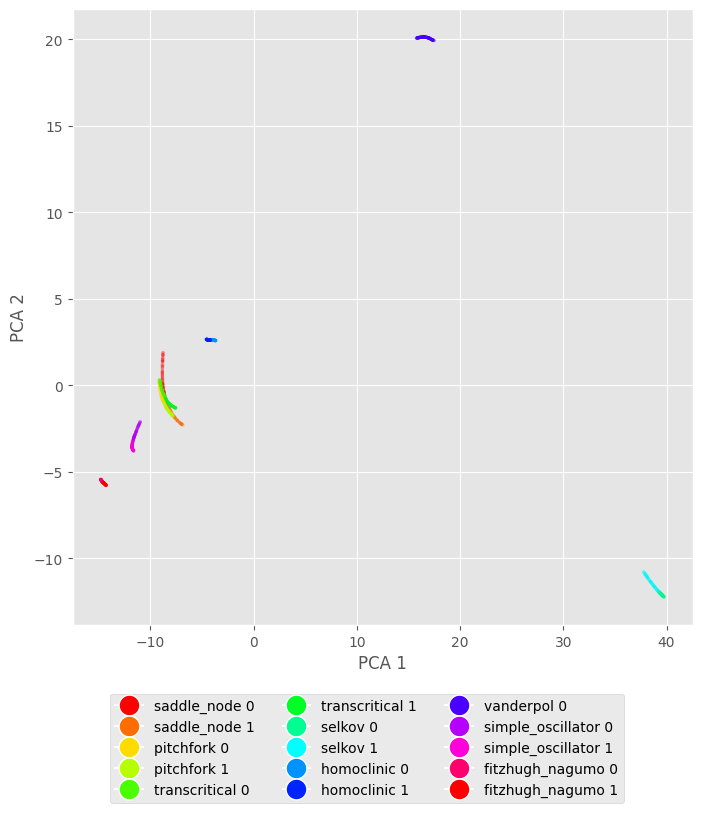

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from src.utils._utils import nearly_square
import colorsys

fig, ax = plt.subplots(figsize=(8, 8))

# Load embeddings
results_dir = f'/home/mgricci/results/phase2vec/{train_info["exp_name"]}'
embeddings = np.load(os.path.join(results_dir,f'embeddings.npy'))

# PCA
pca = PCA(n_components=2)
z   = pca.fit_transform(embeddings)

# Colors and plotting
class_hues = np.linspace(0.0, 1.0, num_test_classes)
class_rgbs = [colorsys.hsv_to_rgb(h,1.0,1.0) for h in class_hues]

colors = [class_rgbs[l] for l in np.sort(y_test)]
ax.scatter(z[:,0], z[:,1], c=np.array(colors), alpha=.1, s=4)

m,n = nearly_square(num_test_classes)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=test_system_classes[l],
                          markerfacecolor=class_rgbs[l], markersize=15) for l in np.unique(y_test)]
ax.legend(handles=legend_elements,bbox_to_anchor=(.9, -.1),ncol=m)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.show()